### MNISTの画像を準備

In [1]:
from matplotlib import pyplot as plt
import torch as tc
from torch import nn
from torch import optim
from torch.nn import functional as F
import torchvision as tv
from torchvision import transforms
from torchvision import datasets as d
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
from scipy.signal import fftconvolve


device = tc.device('cuda:0')
device

device(type='cuda', index=0)

超解像復元の問題は、(連続状態集合S, 可算有限行動集合A, 報酬関数R, 不明な遷移関数T, 初期状態の生起確立P)からなるマルコフ決定過程で表され、高解像の復元画像を表す各状態を表す$s \in \mathbb{R}^{h \times w}$に顕微鏡でのぼやけ具合を表すフィルタを畳み込んだ値と、目標値である低解像度画像$ b \in \mathbb{R}^{(h - p + 1) \times (w - q + 1)}$との差を用いた報酬
$$ R = - \| s - b \|^2 $$
の総和を最大化するような、適切な行動(フィルタ)を決定的方策を学習する課題であると見なす事ができる。 

ここで、問題になるのは、状態集合が連続値で、一回の決定でたどり着ける状態とたどり着けない状態が存在も存在するし、さらには初期状態によって永遠にたどり着けない状態も存在する事である。この問題を解消しないと詰むのでは？  
-> 周期性のないマルコフ決定過程が強化学習問題において、問題なく最適な決定的方策を学習する事ができうるのかを調べる。

In [2]:
# データは num = 0の画像のみ
transform = transforms.Compose([transforms.ToTensor()])
whole_trainset = d.MNIST(root='./data', train=True, download=True, transform=transform)
train_mask = (whole_trainset.targets == 0).nonzero()[:, 0]
trainset = Subset(whole_trainset, train_mask)

whole_testset = d.MNIST(root='./data', train=False, download=True, transform=transform)
test_mask  = (whole_testset.targets == 0).nonzero()[:, 0]
testset = Subset(whole_testset, test_mask)
trainloader = DataLoader(trainset, shuffle=True)
testloader = DataLoader(testset, shuffle=False)

In [3]:
# フィルタのリスト(sharpen, unsharpen, gaussian_blur)
sharpen = 1.0 * tc.tensor([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

unsharp = (-1) * tc.tensor([
    [1, 4, 6, 4, 1],
    [4, 16, 24, 16, 4],
    [6, 24, -476, 24, 6],
    [4, 16, 24, 16, 4],
    [1, 4, 6, 4, 1]
]) / 256.0

gaussian_blur = tc.tensor([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
]) / 16.0

actions = [sharpen, unsharp, gaussian_blur]
action_labels = ['sharpen', 'unsharpen', 'gauusian_blur']

### 環境を用意する
ガウシアンフィルタで３回ぼかした画像を初期state、元の画像を目標画像とする。  
本来の超解像復元では、目標画像が顕微鏡のぼやけフィルタとノイズを経た低解像度画像が目標画像。

In [68]:
train_zero_images = iter(trainloader)
test_zero_images = iter(testloader)

T = 10

class InnerState(object):
    def __init__(self, state_img):
        if not tc.is_tensor(state_img):
            state_img = tc.tensor(state_img).to(device)
        self.x = state_img
        

# 最終的には、これがオートエンコーダーで特徴量抽出したものになる。
class OuterState(object):
    def __init__(self, inner_state):
        # とりあえずそのまま使う
        self.v = inner_state.x
        
        
class ReconstructionEnv(object):
    def __init__(self, train=True):
        self._state = None
        self.train = train
        self._step_count = 1
    
    def reset(self):
        '''
        数字が0のデータからサンプルを選んでくる。
        1)targetとなる画像を、self._bに
        2)targetをぼかした画像を、self._stateにセット
        '''
        self._step_count = 1
        
        #1) 目標画像の準備
        if self.train:
            self._b = train_zero_images.next()[0]
        else:
            self._b = test_zero_images.next()[0]
        self._b = self._b.squeeze(0).squeeze(0).to(device)
        #2) ぼかした画像をstateとしてセット
        self._state = InnerState(self._b)
        for i in range(3):
            self._state = InnerState(
                fftconvolve(self._state.x.cpu(), gaussian_blur, mode='same')
            )
        # ２次元標準正規分布で初期化するパターン
        #self._state = InnerState(tc.randn(self._b.shape))
        
    @property
    def state(self):
        return OuterState(self._state)
    
    def next_state(self, action):
        return InnerState(
            F.relu(tc.tensor(fftconvolve(self._state.x.cpu(), action, mode='same'))).to(device)
        )
    
    def reward_func(self, state, next_state):
        return -tc.sum((self._b - next_state.x)**2)
    
    def step(self, action):
        action = actions[action]
        next_state = self.next_state(action)
        reward = self.reward_func(self._state, next_state)
        done = (self._step_count == T)  # 5回フィルタをかけたら終わり
        self._state = next_state  # そのまま代入して大丈夫。今回の環境では次の状態が常に存在するので。
        self._step_count += 1  # インクリメント
        return OuterState(next_state), reward, done

### 一つ目のトライ。random policyで動かしてみる。

In [52]:
def test_random_policy():
    env = ReconstructionEnv()
    env.reset()
    done = False
    plt.figure(figsize=(12, 9.6))
    plt.title('visited states')
    plt.subplot(1, T + 1, 1)
    plt.axis('off')
    plt.imshow(env._state.x)
    print('回数 = ', T)
    took_actions = []
    while not done:
        a = tc.randint(3, ())
        took_actions.append(action_labels[a.item()])
        next_state, reward, done = env.step(a)
        plt.subplot(1, T + 1, env._step_count)
        plt.axis('off')
        plt.imshow(next_state.v)
    plt.show()
    print(took_actions)

回数 =  10


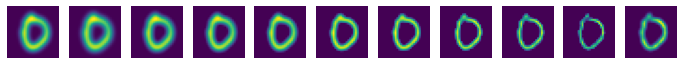

['gauusian_blur', 'unsharpen', 'unsharpen', 'unsharpen', 'sharpen', 'unsharpen', 'sharpen', 'unsharpen', 'sharpen', 'gauusian_blur']


In [115]:
# 3回ぼかした画像で初期化
test_random_policy()

sharpenの威力が結構強いが、一回選んだだけでは、良くならないので参考にはなるか。

回数 =  10


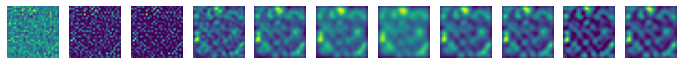

['sharpen', 'sharpen', 'gauusian_blur', 'gauusian_blur', 'gauusian_blur', 'gauusian_blur', 'sharpen', 'unsharpen', 'sharpen', 'gauusian_blur']


In [109]:
# 標準正規分布で初期化
test_random_policy()

元々、stateに対応する高解像度の画像は、手に入らないよね？？
その場合、最初のstateを乱数で生成するしかないが、そのstateからたどり着けるstateは、その最初のstateに選択肢に存在するフィルタをかまして到達できるstateのみ。
この場合、最初のstateは、targetをぼかした画像とかじゃないとそもそも復元できないのでは？

### AgentにValueベースの方策を学習させて行動評価させる

In [18]:
class ConvQualityFunction(nn.Module):
    def __init__(self, action_dim):
        super(ConvQualityFunction, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, action_dim)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# 学習の安定化の工夫
# *) Experience Replay
# *) Fixed Target Network
# *) エピソード終了時の更新

# 1) Fixed Target Networkなし
# 2) アリ
class DQNAgent(object):
    def __init__(self, action_dim=3, eps=0.1, lr=0.1, gamma=0.9):
        self.action_dim = action_dim
        self.eps = eps
        self.gamma = gamma
        self.Q_function = ConvQualityFunction(action_dim)
        self.Q_function.to(device)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.RMSprop(self.Q_function.parameters(), lr=lr)
    
    def policy(self, state, train=False):
        if train and tc.rand(()) < self.eps:
            return tc.randint(self.action_dim, ())
        with tc.no_grad():
            action_qualities = self.Q_function(state.v.unsqueeze(0).unsqueeze(0))
        # Valueベースでactionを決定する
        return tc.argmax(action_qualities)
    
    def update(self, batch):
        # Experience Replayに基づいて行動評価関数のパラメーターを更新する。
        estimation_qualities = []
        true_qualities = []
        for i, e in enumerate(batch):
            est = self.Q_function(e.s.v)
            v = e.r
            if not e.d:
                with tc.no_grad():
                    v += self.gamma * tc.max(self.Q_function(e.ns.v))
            estimation_qualities.append(est[e.a])
            true_qualities.append(v)
        estimation_qualities = tc.stack(estimation_qualities)
        true_qualities = tc.tensor(true_qualities).to(device)
        self.optimizer.zero_grad()
        try:
            loss = self.criterion(estimation_qualities, true_qualities)
            loss.backward()
        except Exception:
            print(estimation_qualities)
            print(true_qualities)
            raise
        self.optimizer.step()

In [53]:
import random
from tqdm.notebook import tqdm
from collections import deque, namedtuple
Experience = namedtuple('Experience', ('s', 'a', 'ns', 'r', 'd'))


def train(agent, seed=0, train_episode_num=10000):
    experiences = deque(maxlen=1024)
    train_count = 0
    reward_records = []
    
    for _ in tqdm(range(train_episode_num)):
        Ri = 0
        env = ReconstructionEnv()
        env.reset()
        done = False
        while not done:
            action = agent.policy(env.state, train=True)
            next_state, reward, done = env.step(action)
            e = Experience(env.state, action, next_state, reward, done)
            Ri += reward
            
        if len(experiences) == 1024:
            batch = random.sample(experiences, 32)
            agent.update(batch)
            train_count += 1
        
        reward_records.append(Ri)
    return reward_records

In [57]:
# FIXME: 
# 1) 行動評価関数に流し込む際に、updateでは、(32, 1, 28, 28)の次元に直す
# 2) policyでは、(1, 28, 28)に直す
seed = 0
random.seed(seed)
tc.random.manual_seed(seed)
agent = DQNAgent(eps=0.1, lr=0.1)
rewards = train(agent, train_episode_num=1000)

In [58]:
def moving_average(r, n=100):
    ret = tc.cumsum(r, dim=0, dtype=tc.float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

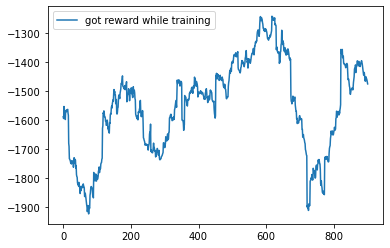

In [59]:
plt.plot(moving_average(tc.tensor(rewards)), label='got reward while training')
plt.legend(loc='best')

In [66]:
def test_policy(agent):
    env = ReconstructionEnv()
    env.reset()
    done = False
    plt.figure(figsize=(12, 9.6))
    plt.title('visited states')
    plt.subplot(1, T + 1, 1)
    plt.axis('off')
    plt.imshow(env._state.x.cpu())
    print('回数 = ', T)
    took_actions = []
    while not done:
        a = agent.policy(env.state)
        took_actions.append(action_labels[a.item()])
        next_state, reward, done = env.step(a)
        plt.subplot(1, T + 1, env._step_count)
        plt.axis('off')
        plt.imshow(next_state.v.cpu())
    plt.show()
    print(took_actions)

回数 =  10


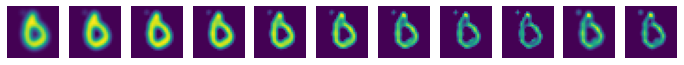

['unsharpen', 'unsharpen', 'unsharpen', 'unsharpen', 'unsharpen', 'unsharpen', 'unsharpen', 'unsharpen', 'gauusian_blur', 'unsharpen']


In [67]:
test_policy(agent)